In [56]:
import pandas_datareader.data as web
from datetime import datetime

start_date = datetime(1990, 1, 1)
unrate = web.DataReader("UNRATE", "fred", start_date)
print(datetime.now())

# 2024-01-01의 3.7%은 2월에 발표된 값임
# 2월 말에는 1월의 정보를 알고 있음
# 3월 초에도 1월의 정보를 알고 있음 (정확히 2월 언제 발표하는 지 다름)
# 따라서 월말 리밸런싱을 함

unrate = web.DataReader("UNRATE", "fred", start_date)
unrate['12ma'] = unrate.rolling(12).mean()
unrate_shifted = unrate.shift(1)

import yfinance as yf
us500 = yf.download('^GSPC')[['Adj Close']]
us500.columns = ['US500']
us500['200ma'] = us500['US500'].rolling(200).mean()

import bt
signal = bt.merge(us500, unrate_shifted)
signal = signal.fillna(method='ffill')


2024-02-07 17:19:37.141544


/home/indi/codespace/PriceTrend/RPAA/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
/tmp/ipykernel_30855/1517396225.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us500['200ma'] = us500['US500'].rolling(200).mean()
/tmp/ipykernel_30855/1517396225.py:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  signal = signal.fillna(method='ffill')


In [59]:
signal = signal['1993':].copy()

In [69]:
cond1 = (signal['US500'] < signal['200ma'])
cond2 = (signal['UNRATE'] > signal['12ma'])
signal['berish'] = (cond1 & cond2) # 1

In [85]:
signal.sort_index()

,US500,200ma,UNRATE,12ma,berish,signal
1993-01-01,4954.229980,4449.898254,7.4,7.491667,False,0
1993-01-04,435.380005,416.682750,7.4,7.483333,False,0
1993-01-05,434.339996,416.797950,7.4,7.483333,False,0
1993-01-06,434.519989,416.921000,7.4,7.483333,False,0
1993-01-07,430.730011,417.030250,7.4,7.483333,False,0
...,...,...,...,...,...,...
2024-01-31,4845.649902,4434.041555,3.7,3.608333,False,0
2024-02-01,4906.189941,4437.815906,3.7,3.608333,False,0
2024-02-02,4958.609863,4441.834604,3.7,3.608333,False,0
2024-02-05,4942.810059,4445.776055,3.7,3.608333,False,0


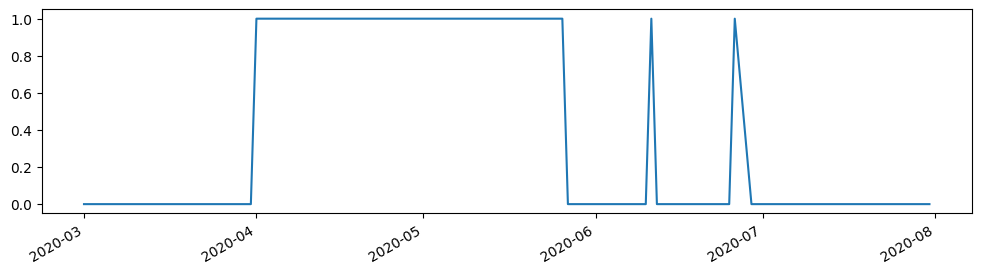

In [86]:
signal['signal'] = signal['berish'].astype('int')
signal.sort_index().loc["2020-03":"2020-07", 'signal'].plot(figsize=(12,3))

signal = signal.sort_index()

<Axes: >

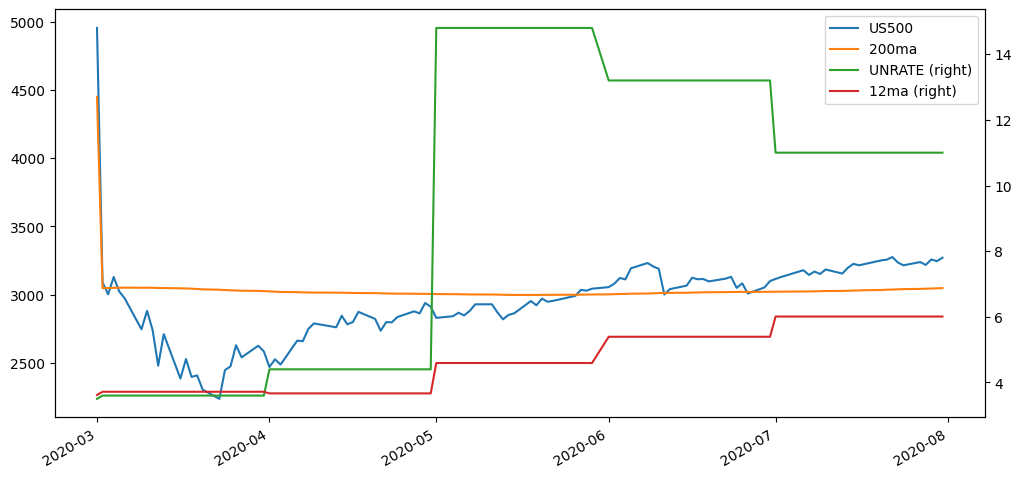

In [88]:
signal.sort_index().loc["2020-03":"2020-07", ['US500', '200ma', 'UNRATE', '12ma']].plot(secondary_y=['UNRATE', '12ma'], figsize=(12,6))

In [90]:
signal

,US500,200ma,UNRATE,12ma,berish,signal
1993-01-01,4954.229980,4449.898254,7.4,7.491667,False,0
1993-01-04,435.380005,416.682750,7.4,7.483333,False,0
1993-01-05,434.339996,416.797950,7.4,7.483333,False,0
1993-01-06,434.519989,416.921000,7.4,7.483333,False,0
1993-01-07,430.730011,417.030250,7.4,7.483333,False,0
...,...,...,...,...,...,...
2024-01-31,4845.649902,4434.041555,3.7,3.608333,False,0
2024-02-01,4906.189941,4437.815906,3.7,3.608333,False,0
2024-02-02,4958.609863,4441.834604,3.7,3.608333,False,0
2024-02-05,4942.810059,4445.776055,3.7,3.608333,False,0


In [91]:
import pandas as pd
price_df = pd.read_csv('laa_assets.csv', index_col=0, parse_dates=True)
price_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5561 entries, 2000-01-31 to 2022-08-05
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   us500_UH      5561 non-null   float64
 1   usbond10y_UH  5561 non-null   float64
 2   kodex200      5561 non-null   float64
 3   kbond10y      5561 non-null   float64
 4   gold_H        5561 non-null   float64
 5   nasdaq100_UH  5561 non-null   float64
 6   usdkrw        5561 non-null   float64
 7   kbond1y       5561 non-null   float64
 8   kbond3y       5561 non-null   float64
 9   gold_UH       5561 non-null   float64
dtypes: float64(10)
memory usage: 477.9 KB


In [92]:
class Config:
    ''' 설정

    (가정1) gold는 gold, gold_H, gold_UH중 하나로 설정한다.
    (가정2) defense와 offense는 1개 이어야 한다.

    KODX200미국채혼합은 kodex200과 usbond10y_UH가 4:6인 자산이다.
    DC의 안전자산(30%)에 KODEX200미국채혼합 ETF를 매수할 수 있다.
    '''
    signal_name = 'Growth_Trend'

    def __init__(self, stocks = {'us500_UH':0.25}, 
                       bonds={'usbond10y_UH':0.25}, 
                       gold = {'gold_UH': 0.25},
                       defense = 'usdkrw', 
                       offense = 'nasdaq100_UH', 
                       is_dc=False, 
                       safe_limit=None, 
                       safe_assets=[]):
        self.stocks = stocks
        self.bonds = bonds
        self.gold = gold
        self.defense = defense
        self.offense = offense
        #-------- is_dc가 True일때만 의미 있음
        self.is_dc = is_dc
        self.safe_limit = safe_limit
        self.safe_assets = safe_assets

        assert(len(gold) == 1)

    @property
    def stocks_weight(self):
        w  = 0.0
        for k in self.stocks:
            w += self.stocks[k]
        return w

    @property
    def bonds_weight(self):
        w  = 0.0
        for k in self.bonds:
            w += self.bonds[k]
        return w

    @property
    def gold_weight(self):
        w  = 0.0
        for k in self.gold:
            w += self.gold[k]
        return w

    @property
    def switch_weight(self):
        w = 1 - self.stocks_weight - self.bonds_weight - self.gold_weight
        return w

    @property
    def tickers(self):
        return list(self.stocks)+list(self.gold)+list(self.bonds)+[self.defense, self.offense]

    @property
    def berish_assets(self):
        return list(self.stocks) + list(self.gold) + list(self.bonds) + [self.defense]

    @property
    def bullish_assets(self):
        return list(self.stocks) + list(self.gold) + list(self.bonds) + [self.offense]

    @property
    def each_weight(self): # stock, bond제외한 2가지 자산 동일 비중 XXX 미사용
        return (1.0-self.bonds_weight-self.stocks_weight)/2

    @property
    def assets(self):
        dict3 = {**self.stocks, **self.bonds, **self.gold}
        dict3[self.defense] = self.switch_weight
        dict3[self.offense] = self.switch_weight
        return dict3

In [93]:
# signal은 해당 달은 모두 동일하다.
class WeighLAA(bt.Algo):
    def __init__(self, config):
        super(WeighLAA, self).__init__()
        self.signal_name = config.signal_name # additonal_data를 읽어 오기 위해 사용
        self.config = config # Config class의 설정값을 사용
        print(f"WeighLAA bonds : {self.config.bonds}")

    def is_berish_and_depression(self, signal): # 현금으로 도망가야 하나?
        return signal == True

    def is_dc(self):
        return self.config.is_dc

    def current_weights(self, target): # 현재 자산의 비중 : 자산의 변화에 따라 비중이 변화한다.
        weights = pd.Series()
        for cname in target.children:
            c = target.children[cname]
            weights[cname] = c.weight
        return weights

    def set_switching_weights(self, weights):
        ''' bonds 자산을 안전 자산으로 취급한다.'''
        안전자산비중 = 0.0
        for asset in self.config.safe_assets: # 안전 자산이 설정되었다면
            안전자산비중 += weights[asset]

        print(f"안전자산비중 : {안전자산비중}, {self.config.safe_limit}")
        if 안전자산비중 < self.config.safe_limit: # 0.3보다 작다면 리밸런싱할 때 안전자산 부터 채워야 한다.
            print(f"@@@@@@ {안전자산비중*100:.2f}% 반드시 안전자산 30% 만들어야 한다 {weights.sum()}@@@@@@")
            필요안전자산비중 = self.config.safe_limit - 안전자산비중 # 얼마나 부족한가?
            전체자산개수 = len(weights)
            안전자산개수 = len(self.config.safe_assets)
            차감할자산비중 = 필요안전자산비중/(전체자산개수 - 안전자산개수 - 1) # -1은 offense, 나머지 자산에서 n빵으로 차감할 비중 계산
            print(f"필요({필요안전자산비중}), 전체({전체자산개수}), 안전({안전자산개수}), 차감({차감할자산비중})")

            # 안전자산 비중으로 설정
            # 기존비중에 1/n로 더해준다. => 이 경우 원래 안전자산의 비중이 동일비중이 아니라면 의도한바가 아닐수도
            # => 비중만큼 증가 시켜준다.
            for ticker in self.config.safe_assets:
                weights[ticker] += (필요안전자산비중 * self.config.assets[ticker]/self.config.safe_limit)

            # 나머지 자산군에서 뺀다.
            for ticker in weights.index:
                if ticker not in self.config.safe_assets:
                    weights[ticker] -= 차감할자산비중

    def __call__(self, target):
        t0 = target.now
        weights = self.current_weights(target) # 해당일자의 비중. 전날 비중을 읽어야 하나?
        # print(t0, weights.index, weights.values)
        signal = target.get_data(self.signal_name) # 전날 시그널 : shifted 된 값을 전달해야 한다.
        if self.is_berish_and_depression(signal.loc[t0].values[0]): # 현금으로 스위칭
            if self.config.offense in weights.index: # 현재투자 자산중에 공격형(offensive) 자산이 있다면
                if weights[self.config.offense] != 0.0: 
                    weights[self.config.defense] = weights[self.config.offense] # 해당 비중 그대로 현금으로 스위칭
                    if self.is_dc():
                        print("나는 DC다 SHY")
                        self.set_switching_weights(weights) # DC/IRP일 경우 안전자산 비중을 맞추어 주어야 한다.

                weights.drop(labels=[self.config.offense], inplace=True) # 해당 자산 삭제
        else: # 나스닥100 으로 스위칭
            if self.config.defense in weights.index: # 현재투자 자산중에 현금(defense) 자산이 있다면
                if weights[self.config.defense] != 0.0: 
                    weights[self.config.offense] = weights[self.config.defense] # 해당 비중 그대로 현금으로 스위칭
                    if self.is_dc():
                        print("나는 DC다 QQQ")
                        self.set_switching_weights(weights)

                weights.drop(labels=[self.config.defense], inplace=True) # 해당 자산 삭제

        # 1년 한번 전체 비중을 맞춘다.
        if t0.month == 12:
            print("=======> 연말리밸런싱")
            for name in weights.index:
                weights[name] = self.config.assets[name]

        target.temp['weights'] = weights

        return True

In [94]:
class SelectAsset(bt.Algo):
    def __init__(self, config):
        super(SelectAsset, self).__init__()
        self.signal_name = config.signal_name
        self.config = config
        print(f"SelectAsset bonds : {self.config.bonds}")

    def is_berish_and_depression(self, signal):
        return signal == True

    def __call__(self, target):
        t0 = target.now 
        signal = target.get_data(self.signal_name)

        if self.is_berish_and_depression(signal.loc[t0].values[0]):
            target.temp["selected"] = self.config.berish_assets
        else:
            target.temp["selected"] = self.config.bullish_assets

        # 최조 할당.
        weights = pd.Series()
        for name in target.temp["selected"]:
            weights[name] = self.config.assets[name]

        target.temp['weights'] = weights

        return True

In [95]:
import bt

In [119]:
def strategy_dynamic(name, price_df, start_date, config):
    # 최초 1회 자산 선택
    once = bt.AlgoStack(bt.algos.RunAfterDate(start_date),
                        bt.algos.RunOnce(),
                        SelectAsset(config),
                        bt.algos.PrintInfo("{now} {name} {temp}"),
                        #PrintTempWeights(),
                        bt.algos.Rebalance())
    # 매월말 WeighLAA()로 비중을 계산하고 - 12월에 모든 자산 동일 비중, 그 외 스위칭 자산만 비중계산 다만 DC는 안전자산 고려
    # 리밸런싱
    laa = bt.AlgoStack(
        bt.algos.RunAfterDate(start_date),
        bt.algos.RunMonthly(run_on_first_date=False, run_on_end_of_period=True, run_on_last_date=False),
        bt.algos.SelectAll(),
        WeighLAA(config),
        #PrintTempWeights(),
        bt.algos.Rebalance()
    )
    st = bt.Strategy(name,
        [
            bt.algos.Or([once, laa])
        ])

    test = bt.Backtest(st, price_df,
           additional_data={config.signal_name:signal[['berish']].shift(1)}, # 스위칭 시그널을 넘겨준다. 하루전 데이터를 위해 shift(1)
           initial_capital=10000000)
    return test

In [120]:
signal.index

DatetimeIndex(['1993-01-01', '1993-01-04', '1993-01-05', '1993-01-06',
               '1993-01-07', '1993-01-08', '1993-01-11', '1993-01-12',
               '1993-01-13', '1993-01-14',
               ...
               '2024-01-24', '2024-01-25', '2024-01-26', '2024-01-29',
               '2024-01-30', '2024-01-31', '2024-02-01', '2024-02-02',
               '2024-02-05', '2024-02-06'],
              dtype='datetime64[ns]', length=8113, freq='B')

In [121]:
signal.loc['2024-01-24']

US500     4868.549805
200ma     4414.592452
UNRATE            3.7
12ma         3.608333
berish          False
signal              0
Name: 2024-01-24 00:00:00, dtype: object

In [122]:
# signal 내 부족한 날짜를 채우고 전날 값으로 채우기
signal = signal.asfreq('B', method='ffill')
signal = signal.fillna(method='ffill')
signal = signal.fillna(method='bfill')
signal

/tmp/ipykernel_30855/4139747131.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  signal = signal.fillna(method='ffill')
/tmp/ipykernel_30855/4139747131.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  signal = signal.fillna(method='bfill')


,US500,200ma,UNRATE,12ma,berish,signal
1993-01-01,4954.229980,4449.898254,7.4,7.491667,False,0
1993-01-04,435.380005,416.682750,7.4,7.483333,False,0
1993-01-05,434.339996,416.797950,7.4,7.483333,False,0
1993-01-06,434.519989,416.921000,7.4,7.483333,False,0
1993-01-07,430.730011,417.030250,7.4,7.483333,False,0
...,...,...,...,...,...,...
2024-01-31,4845.649902,4434.041555,3.7,3.608333,False,0
2024-02-01,4906.189941,4437.815906,3.7,3.608333,False,0
2024-02-02,4958.609863,4441.834604,3.7,3.608333,False,0
2024-02-05,4942.810059,4445.776055,3.7,3.608333,False,0


In [123]:
signal.loc['2010-05-31']

US500     1089.410034
200ma     1104.881898
UNRATE            9.9
12ma            9.675
berish           True
signal              1
Name: 2010-05-31 00:00:00, dtype: object

In [127]:
START_DATE = '1993-01-01'
config = Config(bonds={'usbond10y_UH':0.25})
bt_laa = strategy_dynamic('LAA_0_25', price_df, START_DATE, config)
r_laa = bt.run(bt_laa)

SelectAsset bonds : {'usbond10y_UH': 0.25}
WeighLAA bonds : {'usbond10y_UH': 0.25}
2000-01-31 00:00:00 LAA_0_25 {'selected': ['us500_UH', 'gold_UH', 'usbond10y_UH', 'nasdaq100_UH'], 'weights': us500_UH        0.25
gold_UH         0.25
usbond10y_UH    0.25
nasdaq100_UH    0.25
dtype: float64}
=======> 연말리밸런싱
=======> 연말리밸런싱
=======> 연말리밸런싱
=======> 연말리밸런싱
=======> 연말리밸런싱
=======> 연말리밸런싱
=======> 연말리밸런싱
=======> 연말리밸런싱
=======> 연말리밸런싱
=======> 연말리밸런싱
=======> 연말리밸런싱
=======> 연말리밸런싱
=======> 연말리밸런싱
=======> 연말리밸런싱
=======> 연말리밸런싱
=======> 연말리밸런싱
=======> 연말리밸런싱
=======> 연말리밸런싱
=======> 연말리밸런싱
=======> 연말리밸런싱
=======> 연말리밸런싱
=======> 연말리밸런싱


/home/indi/codespace/PriceTrend/RPAA/lib/python3.10/site-packages/ffn/core.py:191: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.monthly_prices = obj.resample("M").last()  # .dropna()
/home/indi/codespace/PriceTrend/RPAA/lib/python3.10/site-packages/ffn/core.py:193: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.yearly_prices = obj.resample("A").last()  # .dropna()
/home/indi/codespace/PriceTrend/RPAA/lib/python3.10/site-packages/ffn/core.py:191: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.monthly_prices = obj.resample("M").last()  # .dropna()
/home/indi/codespace/PriceTrend/RPAA/lib/python3.10/site-packages/ffn/core.py:193: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.yearly_prices = obj.resample("A").last()  # .dropna()


In [128]:
DC_DEFENSE_ASSET = 'kbond3y' # 현금 usdkrw가 DC에서 매수가 안됨 -> kbond1y, kbond3y
config = Config(
                stocks = {'kodex200': 0.12, 'us500_UH': 0.13},
                bonds={'usbond10y_UH':0.18, 'kbond10y': 0.07},
                gold = {'gold_UH':0.25},
                defense=DC_DEFENSE_ASSET,
                is_dc=True,
                safe_assets=['kodex200', 'usbond10y_UH'],
                safe_limit=0.30
)

bt_laa_dc_mixed_k3 = strategy_dynamic('LAA_DC_mixed_k3', price_df, START_DATE, config)
r_laa_dc_mixed_k3 = bt.run(bt_laa_dc_mixed_k3)

SelectAsset bonds : {'usbond10y_UH': 0.18, 'kbond10y': 0.07}
WeighLAA bonds : {'usbond10y_UH': 0.18, 'kbond10y': 0.07}
2000-01-31 00:00:00 LAA_DC_mixed_k3 {'selected': ['kodex200', 'us500_UH', 'gold_UH', 'usbond10y_UH', 'kbond10y', 'nasdaq100_UH'], 'weights': kodex200        0.12
us500_UH        0.13
gold_UH         0.25
usbond10y_UH    0.18
kbond10y        0.07
nasdaq100_UH    0.25
dtype: float64}
나는 DC다 SHY
안전자산비중 : 0.2801683680364905, 0.3
@@@@@@ 28.02% 반드시 안전자산 30% 만들어야 한다 1.2395128173053245@@@@@@
필요(0.01983163196350951), 전체(7), 안전(2), 차감(0.004957907990877378)
나는 DC다 QQQ
안전자산비중 : 0.30558553048463355, 0.3
=======> 연말리밸런싱
나는 DC다 SHY
안전자산비중 : 0.33456768653805236, 0.3
=======> 연말리밸런싱
나는 DC다 QQQ
안전자산비중 : 0.3148564534486029, 0.3
나는 DC다 SHY
안전자산비중 : 0.324560639031985, 0.3
나는 DC다 QQQ
안전자산비중 : 0.31823498257550314, 0.3
=======> 연말리밸런싱
=======> 연말리밸런싱
=======> 연말리밸런싱
=======> 연말리밸런싱
=======> 연말리밸런싱
나는 DC다 SHY
안전자산비중 : 0.31199211906244606, 0.3
나는 DC다 QQQ
안전자산비중 : 0.3061050076033022, 0.3
나는 DC다 

/home/indi/codespace/PriceTrend/RPAA/lib/python3.10/site-packages/ffn/core.py:191: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.monthly_prices = obj.resample("M").last()  # .dropna()
/home/indi/codespace/PriceTrend/RPAA/lib/python3.10/site-packages/ffn/core.py:193: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.yearly_prices = obj.resample("A").last()  # .dropna()
/home/indi/codespace/PriceTrend/RPAA/lib/python3.10/site-packages/ffn/core.py:191: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.monthly_prices = obj.resample("M").last()  # .dropna()
/home/indi/codespace/PriceTrend/RPAA/lib/python3.10/site-packages/ffn/core.py:193: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.yearly_prices = obj.resample("A").last()  # .dropna()


In [129]:
#%% 중간에 자산 스위칭시에 DC의 경우 안전자산을 고려하지만 연금저축은 그냥 스위칭한다.(차이 발생하지만 미미함)
config = Config(
                stocks = {'kodex200': 0.12, 'us500_UH': 0.13},
                bonds={'usbond10y_UH':0.18, 'kbond10y': 0.07},
                gold = {'gold_UH':0.25},
)
bt_laa_mixed = strategy_dynamic('LAA_mixed', price_df, START_DATE, config)
r_laa_mixed = bt.run(bt_laa_mixed)

SelectAsset bonds : {'usbond10y_UH': 0.18, 'kbond10y': 0.07}
WeighLAA bonds : {'usbond10y_UH': 0.18, 'kbond10y': 0.07}
2000-01-31 00:00:00 LAA_mixed {'selected': ['kodex200', 'us500_UH', 'gold_UH', 'usbond10y_UH', 'kbond10y', 'nasdaq100_UH'], 'weights': kodex200        0.12
us500_UH        0.13
gold_UH         0.25
usbond10y_UH    0.18
kbond10y        0.07
nasdaq100_UH    0.25
dtype: float64}
=======> 연말리밸런싱
=======> 연말리밸런싱
=======> 연말리밸런싱
=======> 연말리밸런싱
=======> 연말리밸런싱
=======> 연말리밸런싱
=======> 연말리밸런싱
=======> 연말리밸런싱
=======> 연말리밸런싱
=======> 연말리밸런싱
=======> 연말리밸런싱
=======> 연말리밸런싱
=======> 연말리밸런싱
=======> 연말리밸런싱
=======> 연말리밸런싱
=======> 연말리밸런싱
=======> 연말리밸런싱
=======> 연말리밸런싱
=======> 연말리밸런싱
=======> 연말리밸런싱
=======> 연말리밸런싱
=======> 연말리밸런싱


/home/indi/codespace/PriceTrend/RPAA/lib/python3.10/site-packages/ffn/core.py:191: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.monthly_prices = obj.resample("M").last()  # .dropna()
/home/indi/codespace/PriceTrend/RPAA/lib/python3.10/site-packages/ffn/core.py:193: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.yearly_prices = obj.resample("A").last()  # .dropna()
/home/indi/codespace/PriceTrend/RPAA/lib/python3.10/site-packages/ffn/core.py:191: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.monthly_prices = obj.resample("M").last()  # .dropna()
/home/indi/codespace/PriceTrend/RPAA/lib/python3.10/site-packages/ffn/core.py:193: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.yearly_prices = obj.resample("A").last()  # .dropna()


## 성과 분석

In [130]:
r_all = bt.run(bt_laa, bt_laa_dc_mixed_k3, bt_laa_mixed,)
r_all.display() # 2000년대 이전 kbond10y 믿기가 좀..

Stat                 LAA_0_25    LAA_DC_mixed_k3    LAA_mixed
-------------------  ----------  -----------------  -----------
Start                2000-01-30  2000-01-30         2000-01-30
End                  2022-08-05  2022-08-05         2022-08-05
Risk-free rate       0.00%       0.00%              0.00%

Total Return         584.07%     578.21%            619.37%
Daily Sharpe         0.81        0.98               0.94
Daily Sortino        1.35        1.63               1.55
CAGR                 8.92%       8.87%              9.16%
Max Drawdown         -21.59%     -15.22%            -15.22%
Calmar Ratio         0.41        0.58               0.60

MTD                  1.31%       1.34%              1.33%
3m                   2.21%       1.05%              1.05%
6m                   1.79%       0.14%              0.14%
YTD                  -2.09%      -3.99%             -3.99%
1Y                   6.22%       1.34%              1.35%
3Y (ann.)            12.52%      11.27%         

/home/indi/codespace/PriceTrend/RPAA/lib/python3.10/site-packages/ffn/core.py:191: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.monthly_prices = obj.resample("M").last()  # .dropna()
/home/indi/codespace/PriceTrend/RPAA/lib/python3.10/site-packages/ffn/core.py:193: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.yearly_prices = obj.resample("A").last()  # .dropna()
/home/indi/codespace/PriceTrend/RPAA/lib/python3.10/site-packages/ffn/core.py:191: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.monthly_prices = obj.resample("M").last()  # .dropna()
/home/indi/codespace/PriceTrend/RPAA/lib/python3.10/site-packages/ffn/core.py:193: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.yearly_prices = obj.resample("A").last()  # .dropna()
/home/indi/codespace/Price

## 전략 실행 2

In [23]:
import bt
import pandas as pd
import pandas_datareader.data as web
from datetime import datetime
import yfinance as yf

start_date = datetime(2020, 1, 1)
unrate = web.DataReader("UNRATE","fred",start_date)#,end_date)
unrate['12ma'] = unrate.rolling(12).mean()
unrate_shifted = unrate.shift(1)
us500 = yf.download('^GSPC')[['Adj Close']]
us500.columns = ['US500']
us500['200ma'] = us500['US500'].rolling(200).mean()
signal = bt.merge(us500, unrate_shifted)
signal = signal.fillna(method='ffill')
cond1 = (signal['US500'] < signal['200ma'])
cond2 = (signal['UNRATE'] > signal['12ma'])
signal['berish'] = (cond1 & cond2)

signal.tail()

/home/indi/codespace/PriceTrend/RPAA/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
/tmp/ipykernel_30855/3932406550.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us500['200ma'] = us500['US500'].rolling(200).mean()
/tmp/ipykernel_30855/3932406550.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  signal = signal.fillna(method='ffill')


,US500,200ma,UNRATE,12ma,berish
2023-01-01,4954.22998,4449.898254,3.5,3.633333,False
2023-04-01,4954.22998,4449.898254,3.5,3.558333,False
2023-07-01,4954.22998,4449.898254,3.6,3.541667,False
2023-10-01,4954.22998,4449.898254,3.8,3.583333,False
2024-01-01,4954.22998,4449.898254,3.7,3.625000,False
